In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import string
import argparse
import os
import glob
import shutil
import pickle

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from captcha.image import ImageCaptcha
from PIL import Image
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer



** Criação dos Datasets de Treino e Teste**


In [2]:
path = "images" 

if os.path.exists(path):
    shutil.rmtree(path)

if not os.path.exists(path):
    os.makedirs(path + "/train")
    os.makedirs(path + "/test")

print("Path existe? {}".format(os.path.exists(path)))


Path existe? True


In [3]:
captchaGenerator = ImageCaptcha(height=65, width=80, font_sizes=[40])

def generate_chatchas(number_that_must_be_in_image, number_of_images, path):
    for i in range(number_of_images):
        number = random.choice(string.digits) + number_that_must_be_in_image + random.choice(string.digits)
        captchaGenerator.write(number, os.path.join(path, number_that_must_be_in_image+"_"+str(i)+"_"+number+".png"))

    for i in range(number_of_images):
        number = " " + number_that_must_be_in_image + random.choice(string.digits)
        captchaGenerator.write(number, os.path.join(path, number_that_must_be_in_image+"_"+str(i)+"_"+number+".png"))

    for i in range(number_of_images):
        number = random.choice(string.digits) + number_that_must_be_in_image + " "
        captchaGenerator.write(number, os.path.join(path, number_that_must_be_in_image+"_"+str(i)+"_"+number+".png"))

number_of_train_samples = 500
number_of_test_samples = 100
                
for i in range(10):
    generate_chatchas(str(i), number_of_train_samples, path +'/train/')
    generate_chatchas(str(i), number_of_test_samples, path +'/test/')

print("Total de imagens para treino {}".format(len(glob.glob(path +'/train/*'))))
print("Total de imagens para teste {}".format(len(glob.glob(path +'/test/*'))))


Total de imagens para treino 15000
Total de imagens para teste 3000



** Análise dos Dados **


In [4]:
all_images = glob.glob(path +'/train/*')

image = np.array(Image.open(all_images[0]))
print("Formato da imagem {}".format(image.shape))


Formato da imagem (65, 80, 3)


In [5]:
import re

train_image_file_names = np.array(list(map(lambda filename: os.path.join(path+'/train', filename), os.listdir(path+'/train'))))
train_image_file_labels = np.array(list(map(lambda x: int(x.split('/')[2].split('_')[0]), train_image_file_names)))

print('Total de Labels para treino: {}'.format(dict(zip(*np.unique(train_image_file_labels, return_counts=True)))))
print('Primeiros 5 Labels para treino: {}'.format(train_image_file_labels[:5]))

test_image_file_names = np.array(list(map(lambda filename: os.path.join(path+'/test', filename), os.listdir(path+'/test'))))
test_image_file_labels = np.array(list(map(lambda x: int(x.split('/')[2].split('_')[0]), test_image_file_names)))

print('Total de Labels para teste: {}'.format(dict(zip(*np.unique(test_image_file_labels, return_counts=True)))))
print('Primeiros 5 Labels para teste: {}'.format(test_image_file_labels[:5]))


Total de Labels para treino: {0: 1500, 1: 1500, 2: 1500, 3: 1500, 4: 1500, 5: 1500, 6: 1500, 7: 1500, 8: 1500, 9: 1500}
Primeiros 5 Labels para treino: [8 1 2 6 0]
Total de Labels para teste: {0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300, 7: 300, 8: 300, 9: 300}
Primeiros 5 Labels para teste: [9 4 3 9 1]


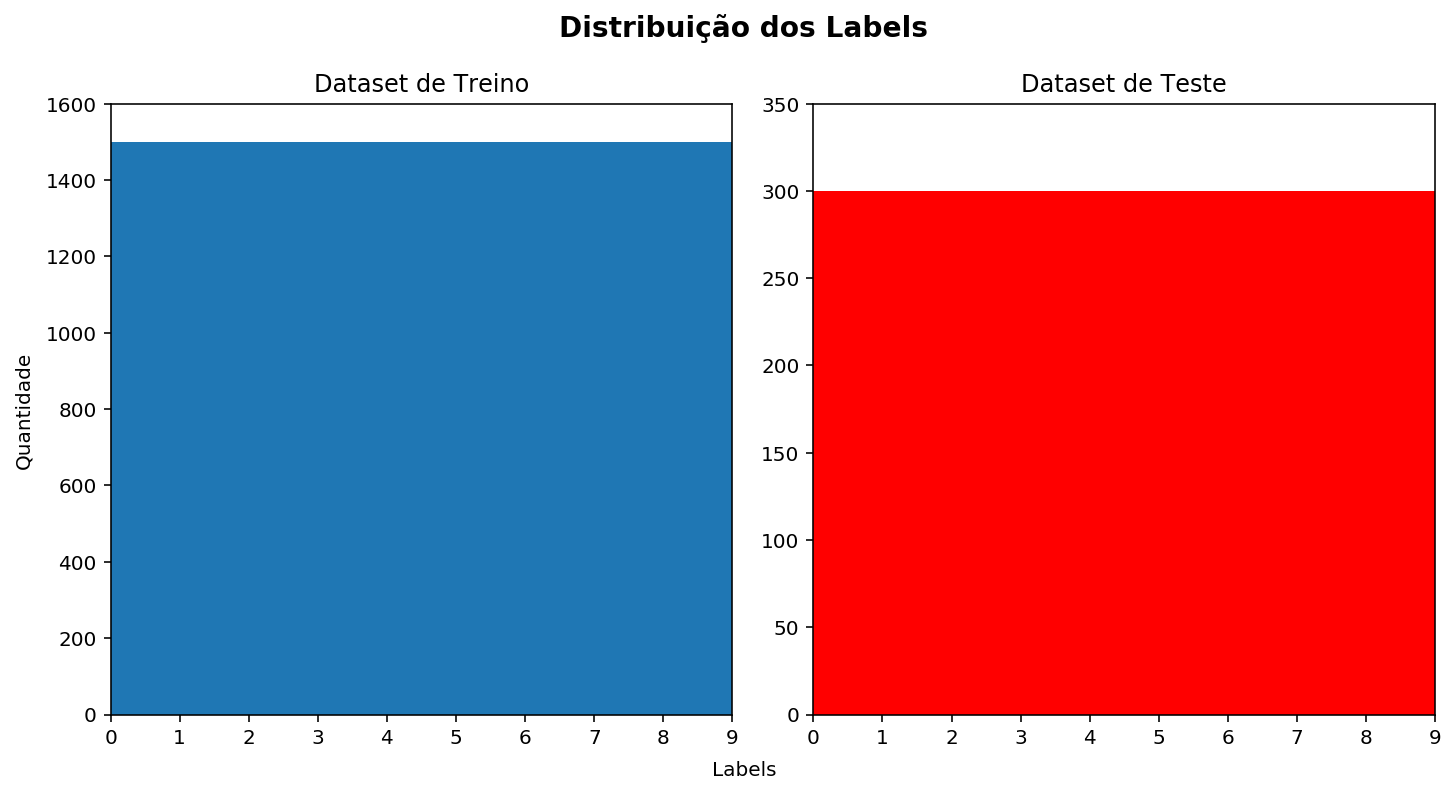

In [6]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Distribuição dos Labels', fontsize=14, fontweight='bold', y=1.05)
fig.text(0.5, 0.0, 'Labels', ha='center', va='center')
fig.text(0.0, 0.5, 'Quantidade', ha='center', va='center', rotation='vertical')

ax1.hist(train_image_file_labels, bins=10)
ax1.set_title("Dataset de Treino")
ax1.set_xlim(0, 9)
ax1.set_ylim(0, 1600)

ax2.hist(test_image_file_labels, color='r', bins=10)
ax2.set_title("Dataset de Teste")
ax2.set_xlim(0, 9)
ax2.set_ylim(0, 350)

fig.tight_layout()

** Pré-processamento dos Dados **

In [7]:
# Metodos auxiliares para preprocessamento de imagens

def normalize(features):
    features_min = features.min(axis=(1, 2), keepdims=True)
    features_max = features.max(axis=(1, 2), keepdims=True)
    features = (features - features_min)/(features_max-features_min)
    return features

possible_labels = [0,1,2,3,4,5,6,7,8,9] 
def one_hot_encode(labels):
    lb = preprocessing.LabelBinarizer()
    lb.fit(possible_labels)
    return lb.transform(labels)

def preprocess_and_save_to_file(features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))
    

In [8]:
# Preprocessamento de imagens

def load_batch(file_names, labels):
    features = np.array(list(map(lambda file: np.array(Image.open(file)), file_names)))
    return features, labels
    
def preprocess_and_save_data_in_pickled_format(train_image_file_names, 
                                               train_image_file_labels,
                                               test_image_file_names,
                                               test_image_file_labels):

    features_batchs = np.array_split(train_image_file_names,9)
    labels_batchs = np.array_split(train_image_file_labels,9)
    
    valid_features = []
    valid_labels = []
    
    # Processando dados de treino
    for batch_id in range(0, len(features_batchs)):
        # Carregando batch de treino
        features, labels = load_batch(features_batchs[batch_id], labels_batchs[batch_id])
        validation_count = int(len(features) * 0.1)

        preprocess_and_save_to_file(features[:-validation_count],
                                    labels[:-validation_count],
                                    'images/preprocess_batch_' + str(batch_id) + '.p')
        
        print('Batch {} de imagens para treino processado com sucesso.'.format(batch_id))

        # Separando 10% dos dados para validacao
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])
    
    # Processando dados que serao usados para validacao durante o treino
    preprocess_and_save_to_file(np.array(valid_features),
                                np.array(valid_labels),
                                'images/preprocess_validation.p')
    
    print('Batch de imagens para validacao processado com sucesso.')

    # Carregando batch de teste
    test_features, test_labels = load_batch(test_image_file_names, test_image_file_labels)

    # Processando dados de teste
    preprocess_and_save_to_file(np.array(test_features),
                                np.array(test_labels),
                                'images/preprocess_testing.p')
    
    print('Batch de imagens para teste processado com sucesso.')
    
train_image_file_names, train_image_file_labels = shuffle(train_image_file_names, train_image_file_labels)  
test_image_file_names, test_image_file_labels = shuffle(test_image_file_names, test_image_file_labels)  
preprocess_and_save_data_in_pickled_format(train_image_file_names, 
                                           train_image_file_labels,
                                           test_image_file_names,
                                           test_image_file_labels)


Batch 0 de imagens para treino processado com sucesso.
Batch 1 de imagens para treino processado com sucesso.
Batch 2 de imagens para treino processado com sucesso.
Batch 3 de imagens para treino processado com sucesso.
Batch 4 de imagens para treino processado com sucesso.
Batch 5 de imagens para treino processado com sucesso.
Batch 6 de imagens para treino processado com sucesso.
Batch 7 de imagens para treino processado com sucesso.
Batch 8 de imagens para treino processado com sucesso.
Batch de imagens para validacao processado com sucesso.
Batch de imagens para teste processado com sucesso.


** Criação da CNN **

In [1]:
# Metodos auxiliares para: image input, label input e a probabilidade de dropout.

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=([None, *image_shape]), name='x')

def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')

def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name='keep_prob')


In [2]:
# Metodos auxiliares para criacao das camadas da CNN.

def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    return tf.contrib.layers.conv2d(inputs=x_tensor, num_outputs=conv_num_outputs, kernel_size=conv_ksize, stride=conv_strides, padding='SAME')

def maxpool(x_tensor, pool_ksize, pool_strides):
    return tf.contrib.layers.max_pool2d(inputs=x_tensor,kernel_size=pool_ksize,stride=pool_strides,padding='SAME')

def flatten(x_tensor):
    return tf.contrib.layers.flatten(inputs=x_tensor)

def fully_conn(x_tensor, num_outputs):
    return tf.contrib.layers.fully_connected(inputs=x_tensor, num_outputs=num_outputs,activation_fn=tf.nn.relu)

def output(x_tensor, num_outputs):
    return tf.contrib.layers.fully_connected(inputs=x_tensor, num_outputs=num_outputs,activation_fn=None)


In [3]:
# Metodo auxiliar para criacao da CNN

def cnn(x_tensor, dropout_keep_prob):
    
    # Convolutional Layer
    x_tensor = conv2d(x_tensor, conv_num_outputs= 32, conv_ksize= (3, 3),conv_strides= (1, 1))
    
    # Pooling Layer
    x_tensor = maxpool(x_tensor, pool_ksize= (2, 2), pool_strides= (2, 2))

    # Convolutional Layer
    x_tensor = conv2d(x_tensor, conv_num_outputs= 64, conv_ksize= (3, 3), conv_strides= (1, 1))
    
    # Pooling Layer
    x_tensor = maxpool(x_tensor, pool_ksize= (2, 2), pool_strides= (2, 2))
    
    # Convolutional Layer
    x_tensor = conv2d(x_tensor, conv_num_outputs= 128, conv_ksize= (3, 3), conv_strides= (1, 1))
    
    # Pooling Layer
    x_tensor = maxpool(x_tensor, pool_ksize= (2, 2), pool_strides= (2, 2))
    
    # Flatten Layer
    x_tensor = flatten(x_tensor)
    
    # TensorFlow Dropout
    x_tensor = tf.nn.dropout(x_tensor, dropout_keep_prob)
    
    # Fully Connected Layers 1
    x_tensor = fully_conn(x_tensor, num_outputs=512)
    
    # TensorFlow Dropout
    x_tensor = tf.nn.dropout(x_tensor, dropout_keep_prob)
    
    # Fully Connected Layers 2
    x_tensor = fully_conn(x_tensor, num_outputs=256)
    
    # TensorFlow Dropout
    x_tensor = tf.nn.dropout(x_tensor, dropout_keep_prob)
    
    # Fully Connected Layers 3
    x_tensor = fully_conn(x_tensor, num_outputs=128)
    
    # TensorFlow Dropout
    x_tensor = tf.nn.dropout(x_tensor, dropout_keep_prob)
    
    # Output Layer
    x_tensor = output(x_tensor, num_outputs = 10)
    
    return x_tensor


In [7]:
# Construindo a CNN

# Inicializacao das variaveis de input, label e keep_prob
x = neural_net_image_input((65, 80, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Criando o Modelo
logits = cnn(x, keep_prob)

# Adicionando identificacao dos logits
logits = tf.identity(logits, name='logits')

# Perda e Otimizador
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Acuracia
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


** Treinamento da CNN**

In [8]:
# Metodos auxiliares para inicializacao do treino, impressao de dados estatisticos durante o treino e carregamento de batch de dados

def train_cnn(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})

def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    
    validation_accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
    train_accuracy  = session.run(accuracy, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})

    print('Perda: {:>10.4f} Acuracia na Validacao: {:.6f} Acuracia no Treino: {:.6f}'.format(loss, validation_accuracy, train_accuracy))

def batch_features_labels(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
        
def load_preprocess_training_batch(batch_id, batch_size):
    filename = '/images/preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


In [9]:
# Carregando dados que serao usados para validacao durante o treino
valid_features, valid_labels = pickle.load(open('/images/preprocess_validation.p', mode='rb'))


In [13]:
epochs = 20
keep_probability = .60
save_model_path = './model'
batch_size=5000

print('Treinando...')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):

        for batch_i in range(9):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_cnn(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, Captcha Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    

Treinando...
Epoch  1, Captcha Batch 0:  Perda:     2.3099 Acuracia na Validacao: 0.103748 Acuracia no Treino: 0.088608
Epoch  1, Captcha Batch 1:  Perda:     2.3023 Acuracia na Validacao: 0.108434 Acuracia no Treino: 0.100600
Epoch  1, Captcha Batch 2:  Perda:     2.3014 Acuracia na Validacao: 0.080991 Acuracia no Treino: 0.098601
Epoch  1, Captcha Batch 3:  Perda:     2.3015 Acuracia na Validacao: 0.124498 Acuracia no Treino: 0.126582
Epoch  1, Captcha Batch 4:  Perda:     2.3024 Acuracia na Validacao: 0.105087 Acuracia no Treino: 0.109927
Epoch  1, Captcha Batch 5:  Perda:     2.3020 Acuracia na Validacao: 0.103748 Acuracia no Treino: 0.101932
Epoch  1, Captcha Batch 6:  Perda:     2.3027 Acuracia na Validacao: 0.118474 Acuracia no Treino: 0.111333
Epoch  1, Captcha Batch 7:  Perda:     2.3018 Acuracia na Validacao: 0.104418 Acuracia no Treino: 0.107333
Epoch  1, Captcha Batch 8:  Perda:     2.3016 Acuracia na Validacao: 0.133199 Acuracia no Treino: 0.119333
Epoch  2, Captcha Batch 

** Validação do Modelo no Dataset de Teste **

INFO:tensorflow:Restoring parameters from ./model
Acuracia nos dados de Teste: 0.9930000901222229



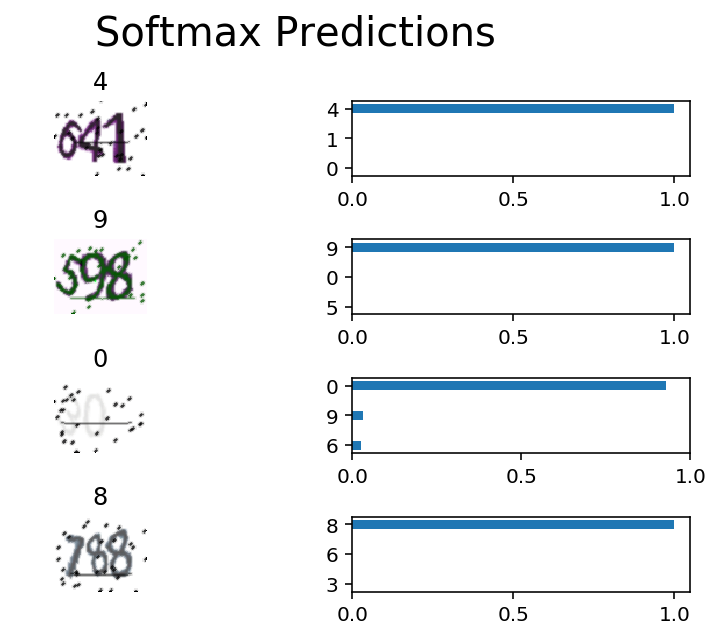

In [14]:
# Testando o modelo
# Obs: Esta parte do codigo foi alterada a partir do codigo 
# https://github.com/udacity/machine-learning/blob/master/projects/image-classification/helper.py

try:
    if batch_size:
        pass
except NameError:
    batch_size = 500

save_model_path = './model'
n_samples = 4
top_n_predictions = 3

def batch_features_labels(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
        
def display_image_predictions(features, labels, predictions):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(10))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = pred_indicies
        correct_name = label_id

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])
        
def test_model():
    test_features, test_labels = pickle.load(open('/images/preprocess_testing.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Carrega o modelo
        loader = tf.train.import_meta_graph(save_model_path+'.meta')
        loader.restore(sess, save_model_path)

        # Pega os tensors previamente nomeados a partir do modelo carregado 
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Pega a acuracia em batchs
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(loaded_acc,
                                             feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Acuracia nos dados de Teste: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Imprime Samples Randomicos
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
                                           feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()
